# [KTO]_Letter_analysis_v1_2210

**분석개요**

    A. 가볼래터 성과 분석 리포트
        1. 매체별 유입 분석
            1) 유입
            2) 재방문
            3) 구독 전환
            4) 이상 유저
            5) 앱설치
        2. 주요 KPI 지표 성과 분석
            1) 유입
            2) 활성
            3) 리텐션
        3. 이동 경로 분석

In [1]:
# basic
import gc
import os
import sys
import warnings
warnings.filterwarnings(action='ignore') 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#--------------------#
# handling
#--------------------#
import math
import time
import random
# import openpyxl
import importlib
import xlsxwriter
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime, timedelta

#--------------------#
# Vis
#--------------------#
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
## Vis for jupyter theme
from IPython.display import Image
from jupyterthemes import jtplot
jtplot.style(theme= 'grade3', context='notebook', ticks=True, grid=False) ## dark backgroud jupyter notebook theme
# plt.style.use(['seaborn-white']) ## dark background style ## white style : 'seaborn-white'
plt.style.use(['dark_background']) ## dark background style ## white style : 'seaborn-white'
## Vis for korean 
import matplotlib.font_manager as fm
font_location = '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf'
fprop = fm.FontProperties(fname=font_location)
font_name = fprop.get_name()
matplotlib.rc('font', family=font_name)

In [2]:
#--------------------#
# sphere package
#--------------------#
sys.path.append("/home/das_share/sphere_class/")
import SpherePackage
from SpherePackage import *
for pkg in [SpherePackage] :
    _ = importlib.reload(pkg)

#--------------------#
# kto package
#--------------------#
sys.path.append("../src/")
import kto_config
import kto_util
import kto_prep
from kto_config import *
from kto_prep import *
from kto_util import *

for pkg in [kto_config, kto_prep, kto_util] :
    _ = importlib.reload(pkg)

# 1.Data Import

In [3]:
#------------------------------------------------#
# 1. log Data import
#------------------------------------------------#
# dates: 10월 한 달
df_app_log = DataImport.read_files(
    input_path = INPUT_PATH + DATA_TYPE + APP_KEY, 
    today = today + timedelta(days = 1), 
    dates = dates,
    platform_total = True, reduce_memory = True, verbose = False)

In [4]:
df_app_log_copy = df_app_log.copy()

# 2.Preprocess

In [5]:
#------------------------------------------------#
# 1. prep
#------------------------------------------------#
## 1) log
df_app_log = SpherePrep.BasicPrep.basic_prep(df_app_log)                # log data

## 2) user prop
df_prop = SpherePrep.Prop.df_prop_pipe(df_app_log, KEY_ID = [KEY_ID_DEVICE, KEY_ID_USER])       # user data
df_prop_manual = KtoPrep.import_prop_manul_data() 
df_prop = pd.merge(
    left = df_prop, right = df_prop_manual[[KEY_ID_USER, 'birth_y' #'gender'
    ]],
    on = KEY_ID_USER, how = 'left')

In [6]:
#------------------------------------------------#
# 1. prep
#------------------------------------------------#
## 3) param - 1
_, df_param_all = DataImport.json_to_dataframe_nodeN(
    df_app_log, [KEY_ID_DEVICE, KEY_ID_USER]
    )

In [ ]:
#------------------------------------------------#
# 1. prep
#------------------------------------------------#
## 3) param - 2
_, df_param_all_session = DataImport.json_to_dataframe_nodeN( 
    df_app_log, [KEY_ID_DEVICE, KEY_ID_USER, 'sid']
    ) ### + param by session

In [7]:
#------------------------------------------------#
# 1. prep
#------------------------------------------------#
## 4) referr
lst_extrated_referr_cols = ['utm_campaign', 'utm_source', 'utm_medium']
df_app_log = SpherePrep.Attribution_Prep.gen_session_referr_cols(
        df_app_log, 
        referr_col = 'referrer', 
        lst_extrated_referr_cols = lst_extrated_referr_cols,
        fill_na_organic = True)

In [8]:
#------------------------------------------------#
# 2. param detail data
#------------------------------------------------#
## 1) event 기준
df_param_contents = DataImport.extract_event_param(df_param_all, EVENT_CONTENT_DETAIL).drop_duplicates()
df_param_subscribe = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE).drop_duplicates()
df_param_letter_main = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE_LETTER).drop_duplicates()
df_param_like = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE_LIKE).drop_duplicates()
df_param_signup = DataImport.extract_event_param(df_param_all, EVENT_SIGNUP).drop_duplicates()

## 2) 가볼래터 data 생성
df_param_contents_letter = df_param_contents[df_param_contents[PARAM_CONTENT_NAME].str.contains('가볼래-터', na=False)]

In [9]:
df_param_contents_letter[PARAM_CONTENT_NAME].unique()

array(['가볼래-터 구독하러 가기', "여행구독 '가볼래-터' 구독자 레벨업을 위한 ★미션 참여 방법& 선물 언박싱★",
       '＇가볼래-터＇구독 신청하고 미션 선물받자!',
       '[2차 앵콜] 다시 돌아온 가볼래-터 깜짝 이벤트! 여행구독 미션 참여하고, 카톡 이모티콘 받자!',
       '대한민국 구석구석 여행구독 서비스! 가볼래-터 구독자 대상 만족도 조사',
       '대한민국 구석구석 여행구독 서비스! 가볼래-터 구독자 대상 만족도 조사 당첨자 발표'], dtype=object)

# 3.Analysis
## 0)Segment Setting

In [10]:
#------------------------------------------------#
# 1. segment by referrer
#------------------------------------------------#
dict_lst_user_from_referrs = KtoPrep.get_user_list_by_referr(
    df_app_log, KEY_ID = KEY_ID_DEVICE,
    DEPTH_1_COL = 'referrer_utm_campaign', 
    DEPTH_2_COL = 'referrer_utm_source') 
dict_lst_user_from_referrs_gudok = dict_lst_user_from_referrs['2022_gudok']
# dict_lst_user_from_referrs_tw['organic']  = dict_lst_user_from_referrs['organic']['organic'] # organic 유입 추가 (optional)

#------------------------------------------------#
# 2. segment by duration per device
#------------------------------------------------#
df_duration_per_device = df_app_log.groupby([KEY_ID_DEVICE])['duration'].sum()
dict_duration_seg = dict()
dict_duration_seg['high'] = df_duration_per_device[
    df_duration_per_device >= df_duration_per_device.quantile(0.66)].index
dict_duration_seg['middle'] = df_duration_per_device[
    (df_duration_per_device < df_duration_per_device.quantile(0.66)) &
    (df_duration_per_device >= df_duration_per_device.quantile(0.33))
    ].index
dict_duration_seg['low'] = df_duration_per_device[
    df_duration_per_device < df_duration_per_device.quantile(0.33)].index

#------------------------------------------------#
# 3. segment by new or re
#------------------------------------------------#
lst_new_device = list(df_app_log[df_app_log['created_date'] >= datetime.strptime(s_date, '%Y%m%d')][KEY_ID_DEVICE].unique())
lst_re_device = list(df_app_log[df_app_log['created_date'] < datetime.strptime(s_date, '%Y%m%d')][KEY_ID_DEVICE].unique())

#------------------------------------------------#
# 4. segment by fraud or total
#------------------------------------------------#
lst_fraud_device = list(df_app_log[df_app_log['duration'] <  5][KEY_ID_DEVICE].unique())
lst_total_device = list(df_app_log[KEY_ID_DEVICE].unique())

#------------------------------------------------#
# 5. segment by demo (gender or age)
#------------------------------------------------#
## gender
dict_seg_gender = dict()
dict_seg_gender['m'] = list(df_prop[df_prop['gender'] == 'm'][KEY_ID_DEVICE])
dict_seg_gender['f'] = list(df_prop[df_prop['gender'] == 'f'][KEY_ID_DEVICE])

## age
dict_seg_age = dict()
dict_seg_age['20_30'] = list(df_prop[(datetime.today().year - df_prop['birth_y']) < 40][KEY_ID_DEVICE])
dict_seg_age['40_50'] = list(df_prop[(datetime.today().year - df_prop['birth_y']) >= 40][KEY_ID_DEVICE])
# # ======================================================== #  next version
# dict_seg_age['20_30'] = list(df_prop[df_prop['age'] < 40][KEY_ID_DEVICE])
# dict_seg_age['40_50'] = list(df_prop[df_prop['age'] >= 40][KEY_ID_DEVICE])

#------------------------------------------------#
# 6. subscribe segment 
#------------------------------------------------#
lst_subscribe_device = list(df_app_log[
    df_app_log['abs_events'].apply(lambda x : True if EVENT_SUBSCRIBE in x else False)
    ][KEY_ID_DEVICE].values)

## 1)매체 유입 성과 분석
### (1) 매체별 유입인원

In [11]:
# 0. prep: instagram, kakao_mo -> drop
del dict_lst_user_from_referrs_gudok['instagram']
del dict_lst_user_from_referrs_gudok['kakao_mo']
dict_lst_user_from_referrs_gudok.keys()

dict_keys(['kakaotalk_bizmessage', 'GDN', 'KAKAO_moment', 'FB_INSTA', 'NAVER_GFA'])

,inflow_cnt
kakaotalk_bizmessage,5327
GDN,4665
KAKAO_moment,2868
FB_INSTA,4447
NAVER_GFA,5102


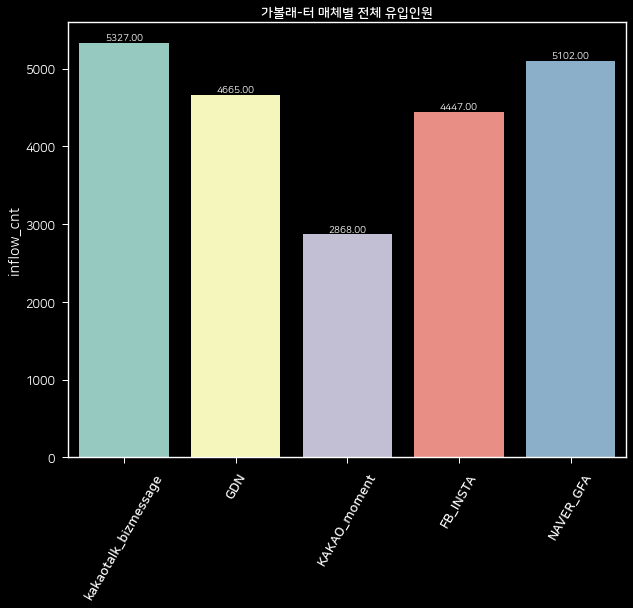

In [12]:
# 1. inflow cnt by referrs
dict_output_inflow_cnt = {}

for keys, values in dict_lst_user_from_referrs_gudok.items():
    dict_output_inflow_cnt[keys] = len(values)

df_vis1 = pd.DataFrame.from_dict(dict_output_inflow_cnt, orient='index', columns=['inflow_cnt'])
df_vis1

SphereVis.basic_bar_plot(
    df_vis1, x = df_vis1.index, y = 'inflow_cnt', title= '가볼래-터 매체별 전체 유입인원')
plt.show()

### (2) 매체별 재방문율

In [13]:
# 2. rate of revisit
## data setting by referrs
dict_id_referrs = {}
dict_df_param_contents = {}
dict_df_log = {}
dict_df_prop = {}

for keys, values in dict_lst_user_from_referrs_gudok.items():
    dict_id_referrs[keys] = values

    dict_df_log[keys] = df_app_log[
                            df_app_log[KEY_ID_DEVICE].isin(
                                dict_id_referrs[keys])]

    dict_df_param_contents[keys] = df_param_contents_letter[
                                        df_param_contents_letter[KEY_ID_DEVICE].isin(
                                            dict_id_referrs[keys])]

    dict_df_prop[keys] = df_prop[
                            df_prop[KEY_ID_DEVICE].isin(
                                dict_id_referrs[keys])]

dict_visit_cnt = {}

for keys, values in dict_df_param_contents.items():
    _df = dict_df_param_contents['GDN'].groupby(KEY_ID_DEVICE)['day'].size().to_frame(
        name = 'day_cnt')
        
    VISIT_1_CNT = len(_df[_df['day_cnt'] == 1])
    VISIT_2_CNT = len(_df[_df['day_cnt'] == 2])
    VISIT_3_CNT = len(_df[_df['day_cnt'] >= 3])

    VISIT_1_RATE = VISIT_1_CNT / len(_df)
    REVISIT_2_RATE= 1 - VISIT_1_RATE
    REVISIT_3_RATE = 1 - ((VISIT_1_CNT + VISIT_2_CNT) / len(_df))

    dict_visit_cnt[f'{keys}'] = [VISIT_1_RATE, REVISIT_2_RATE, REVISIT_3_RATE]

df_vis_revisit = pd.DataFrame.from_dict(
    dict_visit_cnt, orient='index', columns=[
        'only_1_visit', 'revisit_rate', 'revisit_over_3_rate'])

df_vis_revisit

# SphereVis.basic_bar_plot(
#     df_vis_revisit, x = df_vis_revisit.index, y = 'inflow_cnt', title= '가볼래-터 매체별 전체 유입인원')
# plt.show()

,only_1_visit,revisit_rate,revisit_over_3_rate
kakaotalk_bizmessage,0.823085,0.176915,0.068393
GDN,0.823085,0.176915,0.068393
KAKAO_moment,0.823085,0.176915,0.068393
FB_INSTA,0.823085,0.176915,0.068393
NAVER_GFA,0.823085,0.176915,0.068393


### (3)매체별 구독전환율

In [83]:
# 1. landing page > subscribe conversion rate
dict_subscribe_conversion = {}

for key, df in dict_df_param_contents.items():
    _df = df[df[PARAM_CONTENT_NAME] == '가볼래-터 구독하러 가기']
    LANDING_CNT = _df[KEY_ID_DEVICE].nunique()

    _df_subscribe = df_param_subscribe[
                        df_param_subscribe[KEY_ID_DEVICE].isin(
                            list(_df[KEY_ID_DEVICE])
                        )]
    SUBSCRIBE_CNT = _df_subscribe[KEY_ID_DEVICE].nunique()
    
    dict_subscribe_conversion[key] = [LANDING_CNT, SUBSCRIBE_CNT, (SUBSCRIBE_CNT/LANDING_CNT)]

df_subscribe_conversion = pd.DataFrame.from_dict(
    dict_subscribe_conversion, orient='index', columns=[
        'landing_page_user_nums', 'subscribe_user_nums', 'landing_to_subscribe_rate'])

df_subscribe_conversion

,landing_page_user_nums,subscribe_user_nums,landing_to_subscribe_rate
kakaotalk_bizmessage,1649,50,0.030321
GDN,4633,5,0.001079
KAKAO_moment,2867,0,0.000000
FB_INSTA,4446,59,0.013270
NAVER_GFA,5101,26,0.005097


### (4)매체별 Fraud

In [14]:
# 1. fraud user rate & settlement rate
dict_fraud_referrs = {}
for keys, values in dict_df_log.items():
    _df = dict_df_log[keys]
    _df = _df.groupby(KEY_ID_DEVICE)['duration'].sum().reset_index()
    lst_device_fraud = list(_df[KEY_ID_DEVICE][_df['duration'] < 5].unique())

    TOTAL_CNT = _df[KEY_ID_DEVICE].nunique()
    FRAUD_CNT = len(lst_device_fraud)
    FRAUD_RATE = FRAUD_CNT / TOTAL_CNT
    # SETTLE_RATE = 1 - FRAUD_RATE

    dict_fraud_referrs[f'{keys}'] = [TOTAL_CNT, FRAUD_CNT, FRAUD_RATE,  1 - FRAUD_RATE]

df_fraud_referrs = pd.DataFrame.from_dict(
    dict_fraud_referrs, orient='index', columns=[
        'total_cnt', 'fraud_cnt', 'fraud_rate', 'settle_rate'])

df_fraud_referrs

,total_cnt,fraud_cnt,fraud_rate,settle_rate
kakaotalk_bizmessage,5327,682,0.128027,0.871973
GDN,4665,3821,0.819078,0.180922
KAKAO_moment,2868,2717,0.947350,0.052650
FB_INSTA,4447,3789,0.852035,0.147965
NAVER_GFA,5102,4537,0.889259,0.110741


### (5)앱설치 유저 분석

test_th


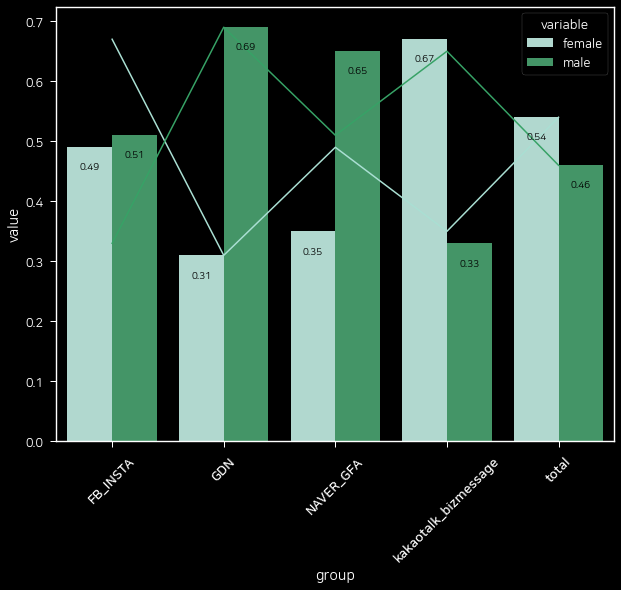

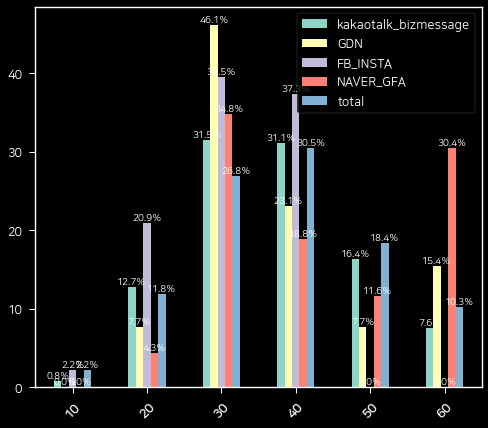

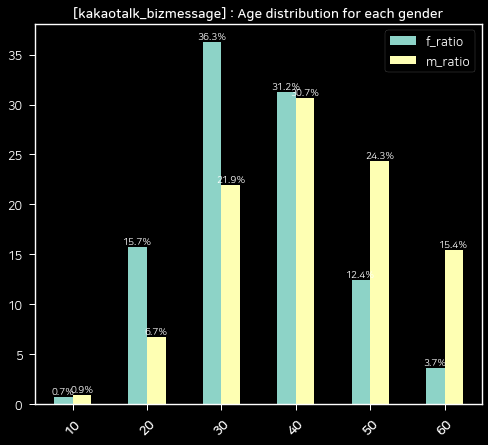

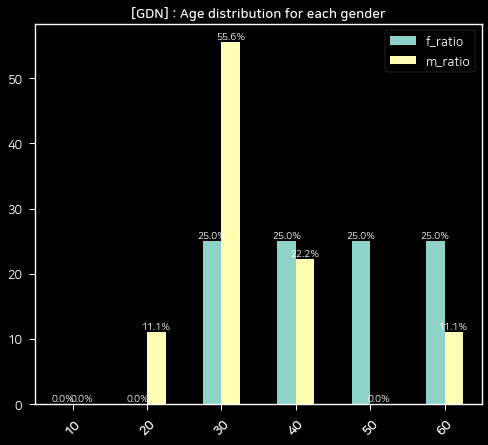

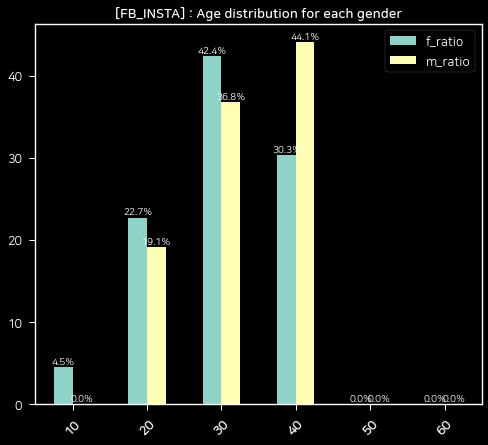

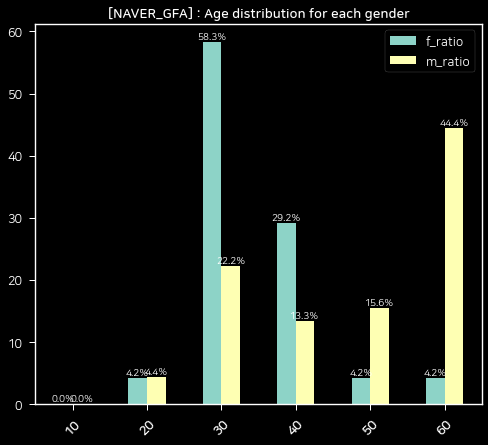

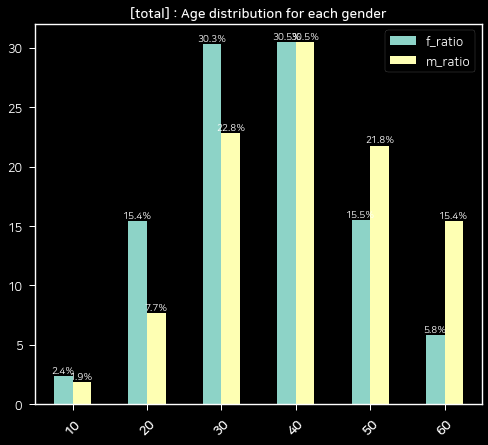

{'kakaotalk_bizmessage': {'age_gender':       m    f   m_ratio   f_ratio  kakaotalk_bizmessage
  10   10   15  0.009107  0.006803                  0.76
  20   74  346  0.067395  0.156916                 12.72
  30  241  800  0.219490  0.362812                 31.52
  40  337  689  0.306922  0.312472                 31.06
  50  267  274  0.243169  0.124263                 16.38
  60  169   81  0.153916  0.036735                  7.57},
 'GDN': {'age_gender':     m  f   m_ratio  f_ratio    GDN
  10  0  0  0.000000     0.00   0.00
  20  1  0  0.111111     0.00   7.69
  30  5  1  0.555556     0.25  46.15
  40  2  1  0.222222     0.25  23.08
  50  0  1  0.000000     0.25   7.69
  60  1  1  0.111111     0.25  15.38},
 'FB_INSTA': {'age_gender':      m   f   m_ratio   f_ratio  FB_INSTA
  10   0   3  0.000000  0.045455      2.24
  20  13  15  0.191176  0.227273     20.90
  30  25  28  0.367647  0.424242     39.55
  40  30  20  0.441176  0.303030     37.31
  50   0   0  0.000000  0.000000      

In [18]:
# 1. gender & age_group 
## KAKAO_moment: drop (설치자 0명이라서)
dict_id_referrs_demo = dict_id_referrs
del dict_id_referrs_demo['KAKAO_moment']

## 시각화
Profiling.demo_profiling(
    df_user_prop=df_prop, KEY_ID=KEY_ID_DEVICE, 
    dict_user_list=dict_id_referrs_demo, 
    total_avg = True, vis_type = 'all')

In [24]:
## exact numbers age/gender by referrs
df_demo_profiling = pd.DataFrame()
for key, lst_id in dict_id_referrs_demo.items():
    _df = df_prop[df_prop[KEY_ID_DEVICE].isin(lst_id)]
    df_demo_profiling = pd.concat(
        df_demo_profiling, _df['gender'].value_counts().to_frame(name = f'{key}_gender'))
    df_demo_profiling = pd.concat(
        df_demo_profiling, _df['age_group'].value_counts().to_frame(name = f'{key}_age'))

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

## 2.주요 KPI 지표 성과 분석

### (1)유입
    - 신규 유입
    - 회원가입 및 구독 완료


### (2)활성
    - 인당 컨텐츠 조회수
    - 검색 조회 빈도
    - 인당 체류 시간

### (3)리텐션
    - 재방문율